# 迁移学习
- 用人家训练好模型的权重参数当做咱们的初始化
- 一般全连接层需要自己训练，可以选择是否训练别人训练好的特征提取层

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
base_dir = './data/cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## tensorflow.keras.applications
- 里面有很多现成训练好的模型可以直接利用

In [3]:
# 导入模型
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
pre_trained_model = ResNet101(input_shape = (75, 75, 3), # 输入大小
                                include_top = False, # 不要最后的全连接层
                                weights = 'imagenet')

## 存放位置
```
C:\Users\用户名\.keras
```

## 使用默认参数，不做更新

In [5]:
for layer in pre_trained_model.layers:
    layer.trainable = False

## callback的作用

- 相当于一个监视器，在训练过程中可以设置一些自定义项，比如提前停止，改变学习率等

callbacks = [

  如果连续两个epoch还没降低就停止：
  
      tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  
  可以动态改变学习率：
  
      tf.keras.callbacks.LearningRateScheduler
      
  保存模型：
  
      tf.keras.callbacks.ModelCheckpoint
      
  自定义方法：
  
      tf.keras.callbacks.Callback
]

In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [7]:
from tensorflow.keras.optimizers import Adam

# 为全连接层准备
x = layers.Flatten()(pre_trained_model.output)
# 加入全连接层，这个需要重头训练的
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
# 输出层
x = layers.Dense(1, activation='sigmoid')(x)           
# 构建模型序列，加载的模型的输入pre_trained_model.input，和自己定义的输出x
model = Model(pre_trained_model.input, x) 
# 对组合好的模型，设置优化器、损失函数等进行设置
model.compile(optimizer = Adam(lr=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (75, 75))     

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (75, 75))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 训练模型
- 加入Callback()模块

In [9]:
time1 = datetime.datetime.now()

callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

print(datetime.datetime.now() - time1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
100/100 - 89s - loss: 1.0039 - acc: 0.5140 - val_loss: 0.8508 - val_acc: 0.5000
Epoch 2/100
100/100 - 75s - loss: 0.7017 - acc: 0.5360 - val_loss: 0.6772 - val_acc: 0.5790
Epoch 3/100
100/100 - 66s - loss: 0.6877 - acc: 0.5455 - val_loss: 0.6909 - val_acc: 0.5000
Epoch 4/100
100/100 - 58s - loss: 0.6859 - acc: 0.5445 - val_loss: 0.6856 - val_acc: 0.5380
Epoch 5/100
100/100 - 61s - loss: 0.6853 - acc: 0.5460 - val_loss: 0.6765 - val_acc: 0.5930
Epoch 6/100
100/100 - 64s - loss: 0.6849 - acc: 0.5570 - val_loss: 0.6920 - val_acc: 0.5010
Epoch 7/100
100/100 - 65s - loss: 0.6904 - acc: 0.5290 - val_loss: 0.6816 - val_acc: 0.5690
Epoch 8/100
100/100 - 57s - loss: 0.6870 - acc: 0.5405 - val_loss: 0.6805 - val_acc: 0.6040
Epoch 9/100
100/100 - 57s - loss: 0.6879 - acc: 0.5440 - val_loss: 0.6733 - val_acc: 0.5840
Epoch 10/100
100/100 - 59s - loss: 0.6814 - acc: 0.5645 - val_loss: 0.6663 - val_acc: 0.6160
Epo

Epoch 87/100
100/100 - 57s - loss: 0.6535 - acc: 0.6055 - val_loss: 0.6132 - val_acc: 0.6770
Epoch 88/100
100/100 - 58s - loss: 0.6578 - acc: 0.6095 - val_loss: 0.6411 - val_acc: 0.6040
Epoch 89/100
100/100 - 58s - loss: 0.6608 - acc: 0.6025 - val_loss: 0.6686 - val_acc: 0.6410
Epoch 90/100
100/100 - 57s - loss: 0.6767 - acc: 0.5900 - val_loss: 0.6547 - val_acc: 0.6760
Epoch 91/100
100/100 - 58s - loss: 0.6696 - acc: 0.5915 - val_loss: 0.6459 - val_acc: 0.6790
Epoch 92/100
100/100 - 57s - loss: 0.6729 - acc: 0.5970 - val_loss: 0.6474 - val_acc: 0.6780
Epoch 93/100
100/100 - 57s - loss: 0.6669 - acc: 0.6075 - val_loss: 0.6608 - val_acc: 0.6380
Epoch 94/100
100/100 - 57s - loss: 0.6673 - acc: 0.6030 - val_loss: 0.6627 - val_acc: 0.6370
Epoch 95/100
100/100 - 56s - loss: 0.6611 - acc: 0.6145 - val_loss: 0.6472 - val_acc: 0.6540
Epoch 96/100
100/100 - 63s - loss: 0.6628 - acc: 0.6185 - val_loss: 0.6375 - val_acc: 0.6790
Epoch 97/100
100/100 - 62s - loss: 0.6665 - acc: 0.6045 - val_loss: 0.

## CPU计算

![1-5](./img/CPU1-5.png)
![Total](./img/CPU95-100_Total.png)

## Colab上GPU计算

![1-5](./img/Colab_GPU1-5.png)
![Total](./img/Colab_GPU95-100_Total.png)

## 绘图展示

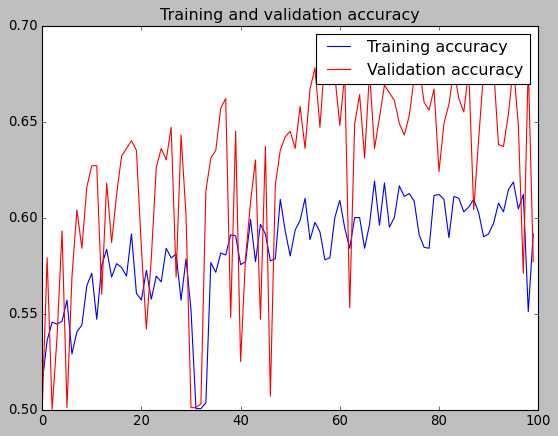

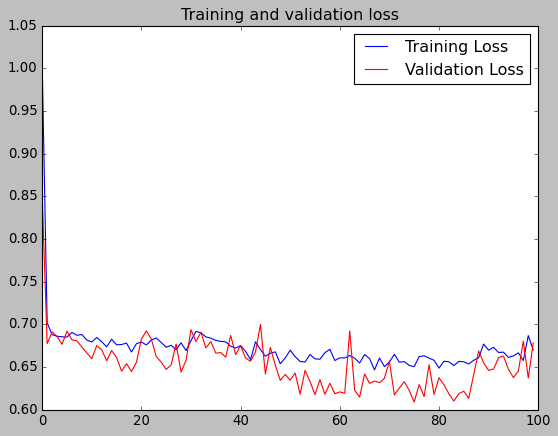

In [10]:
import matplotlib.pyplot as plt
plt.style.use('classic')
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 也可以自己选择需要的层，也就是取到哪一层

- last_layer = pre_trained_model.get_layer('层的名字') 